### Coeff net

In [1]:
import torch
from torch.autograd import Variable
from torch import optim
import torch.nn as nn
import torch.nn.functional as F

import scipy
import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import axes3d

In [2]:
from patsy import dmatrices
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

import m_models as mm
import pickle
from tqdm import tqdm_notebook as tqdm

In [3]:
ort10_coltar10 = pd.read_csv('ort10_coltar10_mean.csv', header=None).values
ort10_colfeat10 = pd.read_csv('ort10_colfeat10_mean.csv', header=None).values
ort20 = pd.read_csv('ort20_mean.csv', header=None).values
ort5_coltar10_colfeat5 = pd.read_csv('ort5_coltar10_colfeat5_mean.csv', header=None).values
ort5_coltar15 = pd.read_csv('ort5_coltar15_mean.csv', header=None).values
ort10_coltar5_colfeat5 = pd.read_csv('ort10_coltar5_colfeat5_mean.csv', header=None).values
ort5_colfeat15 = pd.read_csv('ort5_colfeat15_mean.csv', header=None).values
ort15_colfeat5 = pd.read_csv('ort15_colfeat5_mean.csv', header=None).values
ort5_coltar5_colfeat10 = pd.read_csv('ort5_coltar5_colfeat10_mean.csv', header=None).values

ort10_coltar10_data = pd.read_csv('ort10_coltar10_data.csv', header=None)
ort10_colfeat10_data = pd.read_csv('ort10_colfeat10_data.csv', header=None)
ort20_data = pd.read_csv('ort20_data.csv', header=None)
ort5_coltar10_colfeat5_data = pd.read_csv('ort5_coltar10_colfeat5_data.csv', header=None)
ort5_coltar15_data = pd.read_csv('ort5_coltar15_data.csv', header=None)
ort10_coltar5_colfeat5_data = pd.read_csv('ort10_coltar5_colfeat5_data.csv', header=None)
ort5_colfeat15_data = pd.read_csv('ort5_colfeat15_data.csv', header=None)
ort15_colfeat5_data = pd.read_csv('ort15_colfeat5_data.csv', header=None)
ort5_coltar5_colfeat10_data = pd.read_csv('ort5_coltar5_colfeat10_data.csv', header=None)

In [4]:
true_results = [
    ort10_coltar10,
    ort10_colfeat10,
    ort20,
    ort5_coltar10_colfeat5,
    ort5_coltar15,
    ort10_coltar5_colfeat5,
    ort5_colfeat15,
    ort15_colfeat5,
    ort5_coltar5_colfeat10
]
verify_results = [
    ort5_coltar5_colfeat10
]

In [5]:
datasets = [
    ort10_coltar10_data,
    ort10_colfeat10_data,
    ort20_data,
    ort5_coltar10_colfeat5_data,
    ort5_coltar15_data,
    ort10_coltar5_colfeat5_data,
    ort5_colfeat15_data,
    ort15_colfeat5_data,
    ort5_coltar5_colfeat10_data
]
verify_datasets = [
    ort5_coltar5_colfeat10_data
]

In [6]:
vifs = []

for j in range(len(datasets)):
    datasets[j].columns = [str(chr(i + 97)) for i in range(22)]
    vifs.append([])
    
    for k in range(50, len(datasets[j]), 50):
        features = "+".join(map(str, datasets[j].iloc[:k,:-1].columns))
        y, X = dmatrices('v ~' + features, datasets[j], return_type='dataframe')
    
        vif = np.array(sorted([variance_inflation_factor(X.values, i) for i in range(X.shape[1])]))
        vif[np.isinf(vif)] = 1e10
        vifs[j].append(vif)

/usr/local/lib/python3.7/site-packages/statsmodels/stats/outliers_influence.py:185: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


In [7]:
verify_vifs = []

for j in range(len(verify_datasets)):
    verify_datasets[j].columns = [str(chr(i + 97)) for i in range(22)]
    verify_vifs.append([])
    
    for k in range(50, len(verify_datasets[j]), 50):
        features = "+".join(map(str, verify_datasets[j].iloc[:k,:-1].columns))
        y, X = dmatrices('v ~' + features, verify_datasets[j], return_type='dataframe')
    
        vif = np.array(sorted([variance_inflation_factor(X.values, i) for i in range(X.shape[1])]))
        vif[np.isinf(vif)] = 1e10
        verify_vifs[j].append(vif)

In [8]:
class CoeffNet(nn.Module):
    def __init__(self, dim1=1, dim2=3):
        super().__init__()
        self.fc1 = nn.Linear(dim1, dim1)
        self.fc2 = nn.Linear(dim1, dim2)

    def forward(self, x):
        x = self.fc1(x)
        x = F.leaky_relu(x)
        x = self.fc2(x)
        #x = F.leaky_relu(x)
        
        return x

In [9]:
net = CoeffNet(len(vifs[0][0]), 7)
print(net)

data = [
    [vifs[i][j] / np.max(vifs), true_results[i][:,-1]] 
    for i in range(len(datasets)) 
    for j in range(len(vifs[i]))
]

#criterion = nn.MSELoss()
#optimizer = optim.Adam(net.parameters(), lr=1e-3)

CoeffNet(
  (fc1): Linear(in_features=22, out_features=22, bias=True)
  (fc2): Linear(in_features=22, out_features=7, bias=True)
)


In [11]:
def custom_loss(output, target):
    x = torch.FloatTensor(np.arange(2, 2 + len(target[0])))
    outed = (output[0][0] + 
             output[0][1] / (output[0][2] + x) + 
             output[0][3] / (output[0][4] + x) + 
             output[0][5] * torch.log(torch.abs(output[0][6] + x))
             #output[0][7] * torch.log(torch.abs(output[0][8] + x))
            )
    outed = torch.FloatTensor(outed)

    if any(np.isnan(outed.data.numpy())) or any(np.isinf(outed.data.numpy())):
        print(outed)
        print(output)
        print(output[0][1] / (output[0][2] + x))
        print(output[0][3] / (output[0][4] + x))
        print(output[0][5] * torch.log(output[0][6] + x))
        print(output[0][7] * torch.log(output[0][8] + x))
        #print(output[0][9] / (output[0][10] + torch.exp(-1 * x)))
        
    loss = nn.MSELoss(reduction='sum')(outed, target[0])

    return loss

In [12]:
net = CoeffNet(len(vifs[0][0]), 7)

In [18]:
optimizer = optim.Adam(net.parameters(), lr=5e-5)
for epoch in range(5001):
    full_loss = 0
    for i, data2 in enumerate(data):
        X, Y = iter(data2)
        X, Y = (Variable(torch.FloatTensor([X]), requires_grad=True), 
                Variable(torch.FloatTensor([Y]), requires_grad=False))
        
        optimizer.zero_grad()
        outputs = net(X)
        loss = custom_loss(outputs, Y)
        loss.backward()
        optimizer.step()
        
        full_loss += loss.item()
        
    if (epoch % 100 == 0):
        print("Epoch {} - loss: {}, lr: {}".format(epoch, full_loss, optimizer.param_groups[0]['lr']))

Epoch 0 - loss: 2157.2841700166464, lr: 5e-05
Epoch 100 - loss: 482.9105776399374, lr: 5e-05
Epoch 200 - loss: 480.4629432410002, lr: 5e-05
Epoch 300 - loss: 477.9951406419277, lr: 5e-05
Epoch 400 - loss: 475.50633741915226, lr: 5e-05
Epoch 500 - loss: 473.05423115193844, lr: 5e-05
Epoch 600 - loss: 470.7413231730461, lr: 5e-05


KeyboardInterrupt: 

### Visualization

In [19]:
x = torch.FloatTensor(np.arange(2, 2 + len(true_results[0][:, -1])))

In [24]:
def out_print(output):
    x = torch.FloatTensor(np.arange(2, 2 + len(true_results[0][:, -1])))
    outed = (output[0] + 
             output[1] / (output[2] + x) + 
             output[3] / (output[4] + x) + 
             output[5] * torch.log(torch.abs(output[6] + x)) 
             #output[7] * torch.log(torch.abs(output[8] + x))
            )
    return outed.numpy()

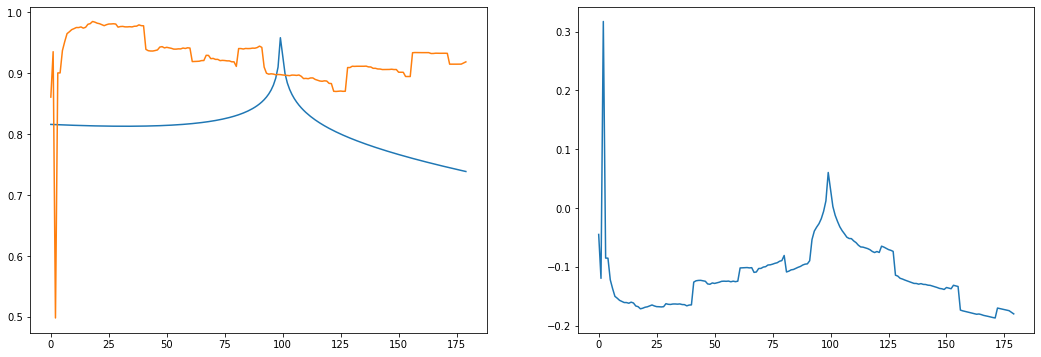

In [25]:
i = 0

fig = plt.figure(figsize=(18, 6))

ax = fig.add_subplot(121)
output = net(Variable(torch.FloatTensor(vifs[i][-1] / np.max(vifs[i][-1])))).data.numpy()
ax.plot(out_print(output))
ax.plot(true_results[i][:, -1])

ax = fig.add_subplot(122)
ax.plot(out_print(output) - true_results[i][:, -1])

In [26]:
X = datasets[i].iloc[:, :-1].values
y = datasets[i].iloc[:, -1].values

In [27]:
methods = {
            'lagrange': lambda X, y: mm.lagrange(X, y),
            'ratio': lambda X, y: mm.likelihood_ratio(X, y),
            'wald': lambda X, y: mm.wald(X, y),
            # 'cross': lambda X, y: mm.cross_val(X, y, k_for_meaning=1000, num = 2, progress_bar=lambda x: tqdm(x, leave = False)),
            # 'apvc': lambda X, y: mm.APVC(X, y, num = 2, progress_bar=lambda x: tqdm(x, leave = False)),
            #'acc': lambda X, y: mm.ACC(X, y, num = 2, progress_bar=lambda x: tqdm(x, leave = False)),
            #'alc': lambda X, y: mm.ALC(X, y, num = 2, progress_bar=lambda x: tqdm(x, leave = False)),
            #'maxu': lambda X, y: mm.MAX_U(X, y, num = 2, progress_bar=lambda x: tqdm(x, leave = False)),
            'kl': lambda X, y: mm.KL_method(X, y, num = 2, progress_bar=lambda x: tqdm(x, leave = False)),
            #'bootstrap': lambda X, y: mm.bootstrap(X, y, num = 2, progress_bar=lambda x: tqdm(x, leave = False)),
#             'logistic': lambda X, y: mm.LogisticRegressionMethod(X, y),
          }

answers = {}
for key in methods.keys():
    print('Calculating ' + key)
    answers[key] = methods[key](X, y)

print('--------------------')
for key in answers.keys():
    print( ('%-10s%s%d')%(key, ' = ', answers[key]['m*']))

Calculating lagrange
Calculating ratio
Calculating wald
Calculating kl


KeyboardInterrupt: 

In [167]:
print(answers['lagrange'])
print(answers['ratio'])
print(answers['wald'])
print(answers['kl'])
print(out_print(output).argmax())
print(true_results[i][:, -1].argmax())

{'m*': 1}
{'m*': 1}
{'m*': 1}
{'m*': 40}
38
18


---

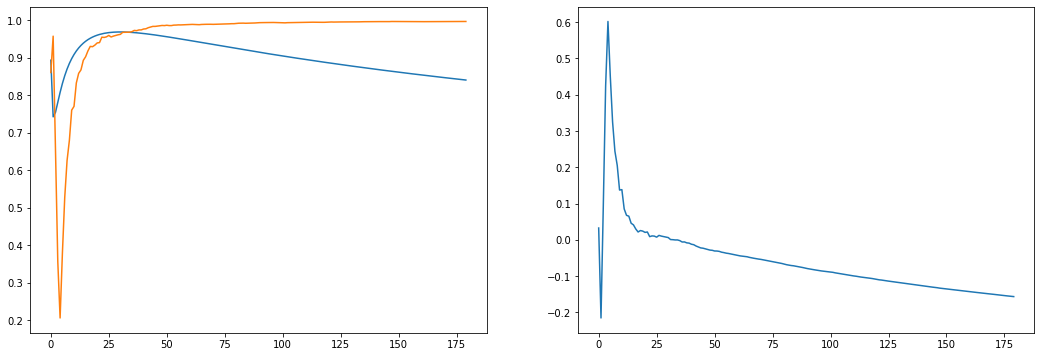

In [168]:
i = 2

fig = plt.figure(figsize=(18, 6))

ax = fig.add_subplot(121)
output = net(Variable(torch.FloatTensor(vifs[i][-1] / np.max(vifs[i][-1])))).data.numpy()
ax.plot(out_print(output))
ax.plot(true_results[i][:, -1])

ax = fig.add_subplot(122)
ax.plot(out_print(output) - true_results[i][:, -1])

In [169]:
X = datasets[i].iloc[:, :-1].values
y = datasets[i].iloc[:, -1].values

In [ ]:
methods = {
            'lagrange': lambda X, y: mm.lagrange(X, y),
            'ratio': lambda X, y: mm.likelihood_ratio(X, y),
            'wald': lambda X, y: mm.wald(X, y),
            #'cross': lambda X, y: mm.cross_val(X, y, k_for_meaning=1000, num = 2, progress_bar=lambda x: tqdm(x, leave = False)),
            #'apvc': lambda X, y: mm.APVC(X, y, num = 2, progress_bar=lambda x: tqdm(x, leave = False)),
            #'acc': lambda X, y: mm.ACC(X, y, num = 2, progress_bar=lambda x: tqdm(x, leave = False)),
            #'alc': lambda X, y: mm.ALC(X, y, num = 2, progress_bar=lambda x: tqdm(x, leave = False)),
            #'maxu': lambda X, y: mm.MAX_U(X, y, num = 2, progress_bar=lambda x: tqdm(x, leave = False)),
            'kl': lambda X, y: mm.KL_method(X, y, num = 2, progress_bar=lambda x: tqdm(x, leave = False)),
            #'bootstrap': lambda X, y: mm.bootstrap(X, y, num = 2, progress_bar=lambda x: tqdm(x, leave = False)),
#             'logistic': lambda X, y: mm.LogisticRegressionMethod(X, y),
          }

answers = {}
for key in methods.keys():
    print('Calculating ' + key)
    answers[key] = methods[key](X, y)

print('--------------------')
for key in answers.keys():
    print( ('%-10s%s%d')%(key, ' = ', answers[key]['m*']))

In [173]:
print(answers['lagrange'])
print(answers['ratio'])
print(answers['wald'])
print(answers['kl'])
print(out_print(output).argmax())
print(true_results[i][:, -1].argmax())

{'m*': 1}
{'m*': 1}
{'m*': 1}
{'m*': 31}
30
176


---

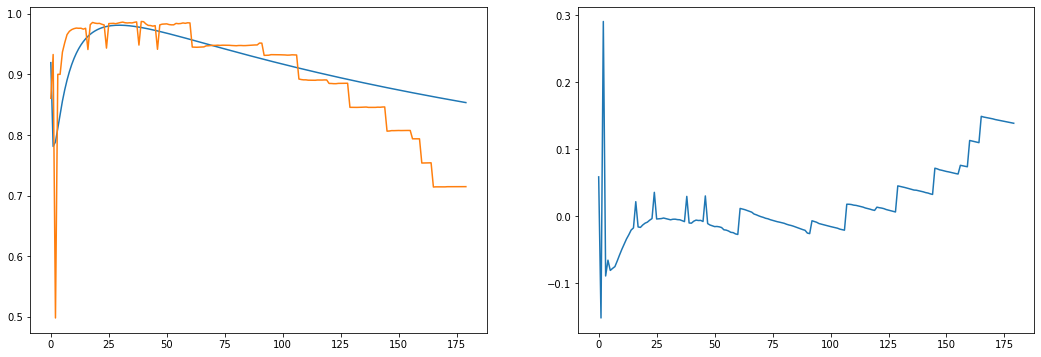

In [175]:
i = 5

fig = plt.figure(figsize=(18, 6))

ax = fig.add_subplot(121)
output = net(Variable(torch.FloatTensor(vifs[i][-1] / np.max(vifs[i][-1])))).data.numpy()
ax.plot(out_print(output))
ax.plot(true_results[i][:, -1])

ax = fig.add_subplot(122)
ax.plot(out_print(output) - true_results[i][:, -1])

In [176]:
X = datasets[i].iloc[:, :-1].values
y = datasets[i].iloc[:, -1].values

In [ ]:
methods = {
            'lagrange': lambda X, y: mm.lagrange(X, y),
            'ratio': lambda X, y: mm.likelihood_ratio(X, y),
            'wald': lambda X, y: mm.wald(X, y),
            #'cross': lambda X, y: mm.cross_val(X, y, k_for_meaning=1000, num = 2, progress_bar=lambda x: tqdm(x, leave = False)),
            #'apvc': lambda X, y: mm.APVC(X, y, num = 2, progress_bar=lambda x: tqdm(x, leave = False)),
            #'acc': lambda X, y: mm.ACC(X, y, num = 2, progress_bar=lambda x: tqdm(x, leave = False)),
            #'alc': lambda X, y: mm.ALC(X, y, num = 2, progress_bar=lambda x: tqdm(x, leave = False)),
            #'maxu': lambda X, y: mm.MAX_U(X, y, num = 2, progress_bar=lambda x: tqdm(x, leave = False)),
            'kl': lambda X, y: mm.KL_method(X, y, num = 2, progress_bar=lambda x: tqdm(x, leave = False)),
            #'bootstrap': lambda X, y: mm.bootstrap(X, y, num = 2, progress_bar=lambda x: tqdm(x, leave = False)),
#             'logistic': lambda X, y: mm.LogisticRegressionMethod(X, y),
          }

answers = {}
for key in methods.keys():
    print('Calculating ' + key)
    answers[key] = methods[key](X, y)

print('--------------------')
for key in answers.keys():
    print( ('%-10s%s%d')%(key, ' = ', answers[key]['m*']))

In [180]:
print(answers['lagrange'])
print(answers['ratio'])
print(answers['wald'])
print(answers['kl'])
print(out_print(output).argmax())
print(true_results[i][:, -1].argmax())

{'m*': 1}
{'m*': 1}
{'m*': 1}
{'m*': 46}
29
39


---

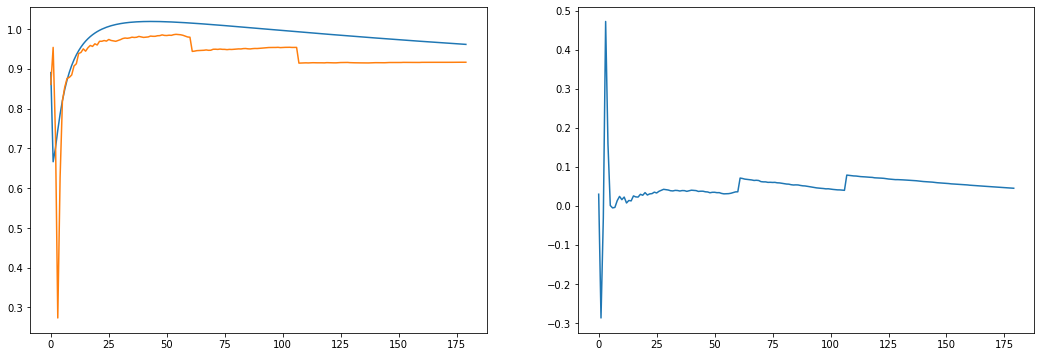

In [181]:
i = 7

fig = plt.figure(figsize=(18, 6))

ax = fig.add_subplot(121)
output = net(Variable(torch.FloatTensor(vifs[i][-1] / np.max(vifs[i][-1])))).data.numpy()
ax.plot(out_print(output))
ax.plot(true_results[i][:, -1])

ax = fig.add_subplot(122)
ax.plot(out_print(output) - true_results[i][:, -1])

In [131]:
output

array([ 1.1045618e+00,  7.2924852e-02, -1.9528936e+01, -4.9893050e+00,
        9.2196064e+00, -4.6598632e-02, -1.2701350e+01, -6.8276264e-03,
       -8.7437992e+00, -1.8992295e+00, -1.7577099e+01], dtype=float32)

генетика + левенберг-марквардт

---

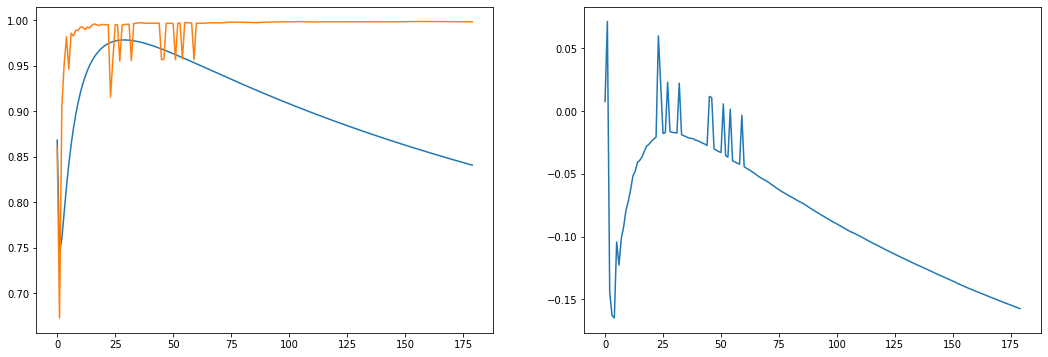

In [182]:
i = 0

fig = plt.figure(figsize=(18, 6))

ax = fig.add_subplot(121)
output = net(Variable(torch.FloatTensor(verify_vifs[i][-1] / np.max(vifs[i][-1])))).data.numpy()
ax.plot(out_print(output))
ax.plot(verify_results[i][:, -1])

ax = fig.add_subplot(122)
ax.plot(out_print(output) - verify_results[i][:, -1])